##### Wikipedia Vandalism Detetection Using Classification and Regression Trees

In [13]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score,GridSearchCV



#### Data Preparation

In [14]:
#Load the dataset
df = pd.read_csv("wikipedia_vandalism_dataset.csv")
#inspect the columns
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   revid               1067 non-null   int64  
 1   user                1067 non-null   object 
 2   timestamp           1067 non-null   object 
 3   comment             921 non-null    object 
 4   size                1067 non-null   int64  
 5   diff_size           1043 non-null   float64
 6   article             1067 non-null   object 
 7   possible_vandalism  1067 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 59.5+ KB
None


In [19]:
#Preprocessing the data for machine learning
def preprocess_data(df):
    
    #Impute missing comments
    df["comment"] = df["comment"].fillna("[No comment]")
    
    # Create binary features
    df["has_comment"] = df["comment"] != "[No comment]"
    df["is_anonymous"] = df["user"] == "anonymous"
    
    #Feature Extraction from timestamp
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["hour_of_day"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.day_of_week
    
    #Feature extraction from comment
    df["comment_length"] = df["comment"].str.len()
    df["contains_revert"] = df["comment"].str.contains("revert", case=False)
    df["contains_vandal"] = df["comment"].str.contains("vandal", case=False)
    
    #Encode categorical variables
    le = LabelEncoder()
    df["article"] = le.fit_transform(df["article"])
    df["user"] = le.fit_transform(df["user"])
    
    #Drop NaN values
    df["diff_size"] =  df["diff_size"].dropna()

    
    
    
    return df

In [20]:
df.head()

,revid,user,timestamp,comment,size,diff_size,article,possible_vandalism,has_comment,is_anonymous,hour_of_day,day_of_week,comment_length,contains_revert,contains_vandal
0,1280441101,182,2025-03-14 17:09:40+00:00,/* top */ ce,342624,4.0,7,False,True,False,17,4,12,False,False
1,1280437000,416,2025-03-14 16:44:22+00:00,Undid revision [[Special:Diff/1280435818|12804...,342620,-61.0,7,False,True,False,16,4,291,False,False
2,1280436783,182,2025-03-14 16:43:10+00:00,/* top */ ce,342681,-14.0,7,False,True,False,16,4,12,False,False
3,1280435818,182,2025-03-14 16:37:27+00:00,/* top */ the side ventures started before and...,342695,61.0,7,False,True,False,16,4,90,False,False
4,1280429047,416,2025-03-14 15:56:49+00:00,Undid revision [[Special:Diff/1280425225|12804...,342634,-474.0,7,False,True,False,15,4,190,False,False


##### Explore the data
- Explore the dataset characteristics: vandalism cases, average word addition subtractions

In [21]:
#Calculate the key metrics
total_revisions = len(df)
vandalism_cases = df["possible_vandalism"].sum()
vandalism_rate = df["possible_vandalism"].mean() * 100
large_changes = (df["diff_size"]> 1000).sum()
large_changes_pct = (large_changes/total_revisions)*100
revert_mentions = df["contains_revert"].sum()
revert_mentions_pct = (revert_mentions/total_revisions) * 100
vandalism_mentions = df["contains_vandal"].sum()

print("The total number of revision is : {}".format(total_revisions))
print("The total number of vandalism cases is:{}".format(vandalism_cases))
print("The vandalism rate is : {}".format(round(vandalism_rate), 2))
print("The total number significant changes is : {}".format(large_changes))
print("The percentage of significant changes is : {}".format(round(large_changes_pct, 2)))
print("The total number of revert mentions is : {}".format(revert_mentions))
print("The percentage of revert mentions is : {}".format(round(revert_mentions_pct, 2)))
print("The total number of vandalism mentions is : {}".format(vandalism_mentions))

The total number of revision is : 1067
The total number of vandalism cases is:104
The vandalism rate is : 10
The total number significant changes is : 26
The percentage of significant changes is : 2.44
The total number of revert mentions is : 55
The percentage of revert mentions is : 5.15
The total number of vandalism mentions is : 5


#### Split the data
 - Split the data into training (70%) and test (30%) set

In [22]:
#Create a feature matrix X and target vector y. "possible_vandalism" is the target
target = "possible_vandalism"
feature = [
        'size', 
        'diff_size', 
        'user', 
        'article', 
        'has_comment', 
        'is_anonymous', 
        'hour_of_day', 
        'day_of_week', 
        'comment_length', 
        'contains_revert', 
        'contains_vandal'
]
X = df[feature]

y = df[target]
# Split nto the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Build the model
- Calculate the baseline score for the model


In [23]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline accuracy is:", round(acc_baseline, 2))

Baseline accuracy is: 0.9


- Train the model

In [24]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

- Use cross validation to select the optimal cp parameter

In [25]:
# Define the parameter grid
param_grid = {"ccp_alpha":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]}

# Perform the cross-validation using the gridsearch cv
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
# Get the best parameter
best_cp = grid_search.best_params_['ccp_alpha']
print(f"Optimal cp (ccp_alpha): {best_cp}")

Optimal cp (ccp_alpha): 0.0001


In [26]:
# Train the model with the best parameter
model = DecisionTreeClassifier(ccp_alpha=best_cp, random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0001, random_state=42)

In [27]:
#Evaluate the model score
accuracy = model.score(X_test, y_test)
print(f" Model Accuracy: {accuracy:.4f}")

 Model Accuracy: 1.0000


- Plot the decision tree and identify relevant variables

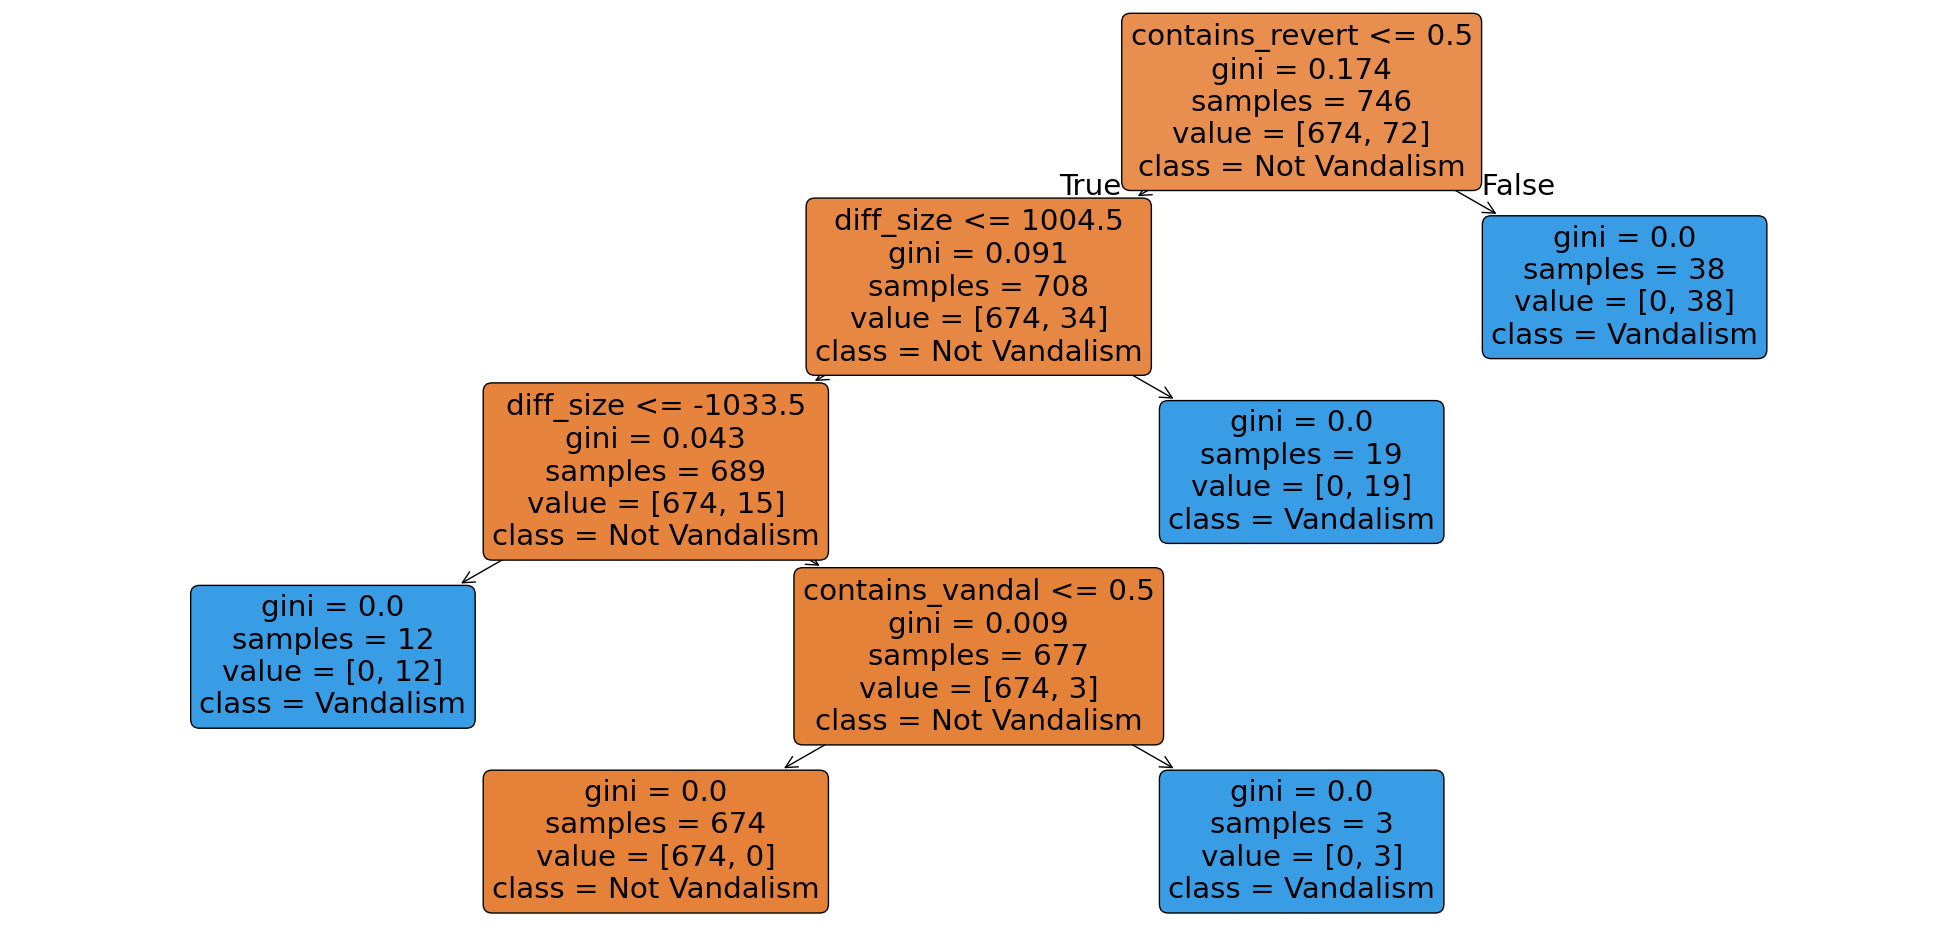

In [28]:
#Plot the drcision tree
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(model, 
          feature_names=X_train.columns,  
          class_names=['Not Vandalism', 'Vandalism'],
          filled=True, 
          rounded=True,
          ax=ax)
plt.savefig('cart_tree.png', dpi=300)
plt.show()

In [29]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

Top 10 most important features:
            Feature  Importance
9   contains_revert    0.502433
1         diff_size    0.451654
10  contains_vandal    0.045913
0              size    0.000000
2              user    0.000000
3           article    0.000000
4       has_comment    0.000000
5      is_anonymous    0.000000
6       hour_of_day    0.000000
7       day_of_week    0.000000


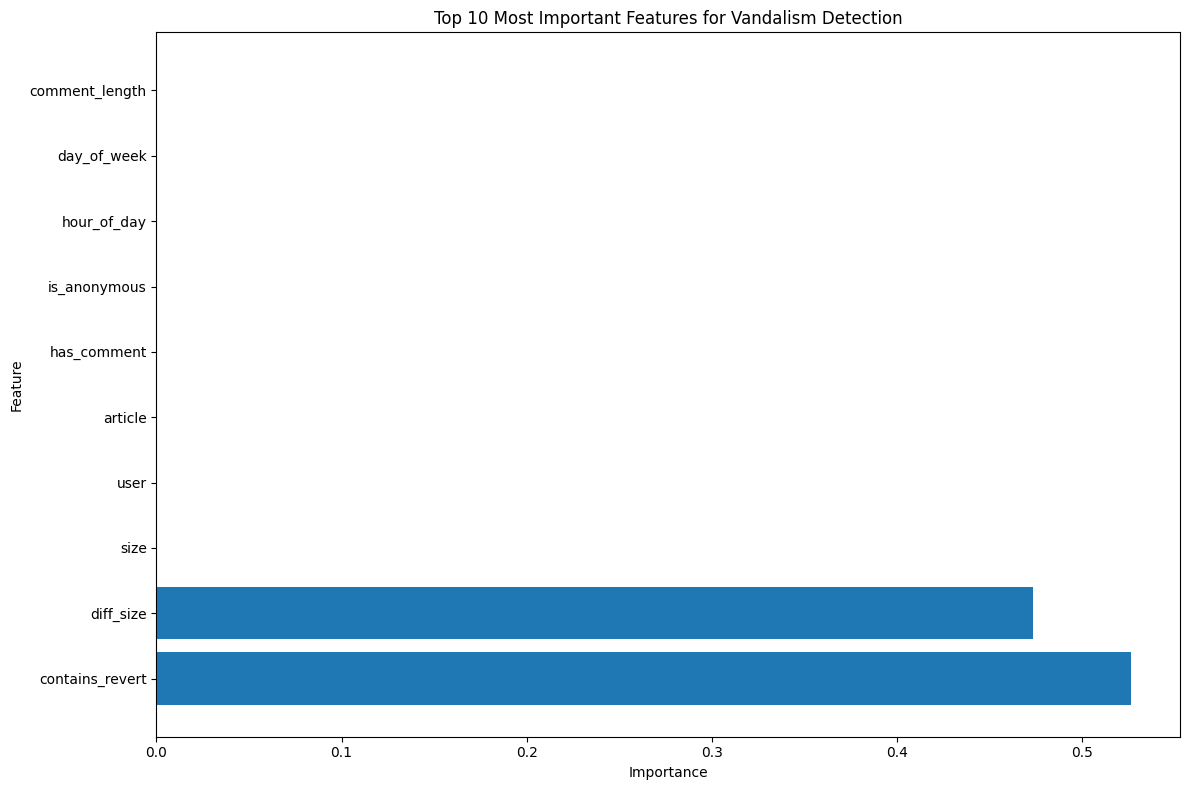

In [ ]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for Vandalism Detection')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

- Build random forest model with 200 trees and node size 25


In [30]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_leaf_nodes=25,
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=25, n_estimators=200, random_state=42)

- Evaluate random forest model accuracy score on test set

In [34]:
rf_accuracy = rf_model.score(X_test, y_test)
rf_accuracy

0.9968847352024922

##### Communicating the insights
- The total number of revisions : 1067
- The total number of vandalism cases: 104
- Vandalism rate: 10 %
- The total number of significant changes (above 1000 characters): 26
- The percentage of significant changes : 2.44%
- The total number of revert mentions: 55
- The percentage of revert mention : 5.15%
- The total number of vandalism mentions: 5
- The model attained a baseline score of 90%
- The model itself attained a score of 100%, probably because of the small nature of the sample size
- Only two features - diff_size and contains_vandalism - were important in classifying the revisions as either harmful or harmless.
- Vandalism detection system can be used as a monitoring system to identify coordinated vandalism attack

__Recommendations__

Future work could enhance the work through:
- Incorporating natural language processing for deeper analysis
- Creating specialized detectors for different vandalism types
